In [0]:
#!pip install scipy==1.1.0

In [3]:
# Run this cell before the lab !
# It will download PascalVOC dataset (400Mo) and 
# pre-computed representations of images (450Mo)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op

import tarfile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve


URL_VOC = ("http://host.robots.ox.ac.uk/pascal/VOC/"
           "voc2007/VOCtrainval_06-Nov-2007.tar")
FILE_VOC = "VOCtrainval_06-Nov-2007.tar"
FOLDER_VOC = "VOCdevkit"

if not op.exists(FILE_VOC):
    print('Downloading from %s to %s...' % (URL_VOC, FILE_VOC))
    urlretrieve(URL_VOC, './' + FILE_VOC)

if not op.exists(FOLDER_VOC):
    print('Extracting %s...' % FILE_VOC)
    tar = tarfile.open(FILE_VOC)
    tar.extractall()
    tar.close()

URL_REPRESENTATIONS = ("https://github.com/m2dsupsdlclass/lectures-labs/"
                       "releases/download/0.2/voc_representations.h5")
FILE_REPRESENTATIONS = "voc_representations.h5"

if not op.exists(FILE_REPRESENTATIONS):
    print('Downloading from %s to %s...'
          % (URL_REPRESENTATIONS, FILE_REPRESENTATIONS))
    urlretrieve(URL_REPRESENTATIONS, './' + FILE_REPRESENTATIONS)

Extracting VOCtrainval_06-Nov-2007.tar...


# Classification and Localisation model

The objective is to build and train a classification and localisation network. This exercise will showcase the flexibility of Deep Learning with several, heterogenous outputs (bounding boxes and classes)

We will build the model in three consecutive steps:
- **Extract label annotations** from a standard Object Detection dataset, namely **Pascal VOC 2007**;
- Use a pre-trained image classification model (namely ResNet50) to **precompute convolutional representations** with shape `(7, 7, 2048)` for all the images in the object detection training set;
- **Design and train a baseline object detection model with two heads** to predict: 
  - class labels (5 possible classes)
  - bounding box coordinates of a single detected object in the image

Note that the simple baseline model presented in this notebook will only detect a single occurence of a class per image. More work would be required to detect all possible object occurences in the images. See the lecture slides for refernces to state of the art object detection models such as Faster RCNN and YOLO9000.


## Loading images and annotations

We will be using Pascal VOC 2007, a dataset widely used in detection and segmentation http://host.robots.ox.ac.uk/pascal/VOC/ To lower memory footprint and training time, we'll only use 5 classes: "dog", "cat", "bus", "car", "aeroplane". Here are the first steps:
- Load the annotations file from pascalVOC and parse it (xml file)
- Keep only the annotations we're interested in, and containing a single object
- Pre-compute ResNet conv5c from the corresponding images


In [0]:
from __future__ import division
import numpy as np
import xml.etree.ElementTree as etree
import os
import os.path as op

# Parse the xml annotation file and retrieve the path to each image,
# its size and annotations
def extract_xml_annotation(filename):
    z = etree.parse(filename)
    objects = z.findall("./object")
    size = (int(z.find(".//width").text), int(z.find(".//height").text))
    fname = z.find("./filename").text
    dicts = [{obj.find("name").text:[int(obj.find("bndbox/xmin").text), 
                                     int(obj.find("bndbox/ymin").text), 
                                     int(obj.find("bndbox/xmax").text), 
                                     int(obj.find("bndbox/ymax").text)]} 
             for obj in objects]
    return {"size": size, "filename": fname, "objects": dicts}

In [0]:
# Filters annotations keeping only those we are interested in
# We only keep images in which there is a single item
annotations = []

filters = ["dog", "cat", "bus", "car", "aeroplane"]
idx2labels = {k: v for k, v in enumerate(filters)}
labels2idx = {v: k for k, v in idx2labels.items()}

annotation_folder = "VOCdevkit/VOC2007/Annotations/"
for filename in sorted(os.listdir(annotation_folder)):
    annotation = extract_xml_annotation(op.join(annotation_folder, filename))

    new_objects = []
    for obj in annotation["objects"]:
        # keep only labels we're interested in
        if list(obj.keys())[0] in filters:
            new_objects.append(obj)

    # Keep only if there's a single object in the image
    if len(new_objects) == 1:
        annotation["class"] = list(new_objects[0].keys())[0]
        annotation["bbox"] = list(new_objects[0].values())[0]
        annotation.pop("objects")
        annotations.append(annotation)

In [6]:
print("Number of images with annotations:", len(annotations))

Number of images with annotations: 1264


In [7]:
print("Contents of annotation[0]:\n", annotations[0])

Contents of annotation[0]:
 {'size': (500, 333), 'filename': '000007.jpg', 'class': 'car', 'bbox': [141, 50, 500, 330]}


In [8]:
print("Correspondence between indices and labels:\n", idx2labels)

Correspondence between indices and labels:
 {0: 'dog', 1: 'cat', 2: 'bus', 3: 'car', 4: 'aeroplane'}


## Pre-computing representations

Before designing the object detection model itself, we will pre-process all the dataset to project the images as spatial maps in a `(7, 7, 2048)` dimensional space once and for all. The goal is to avoid repeateadly processing the data from the original images when training the top layers of the detection network.


**Exercise**: Load a headless pre-trained `ResNet50` model from Keras and all the layers after the `AveragePooling2D` layer (included):

In [0]:
# TODO

headless_conv = None

In [10]:
# %load solutions/load_pretrained.py
from keras.applications.resnet50 import ResNet50
from keras.models import Model

model = ResNet50(include_top=False)
input = model.layers[0].input

# Remove the average pooling layer
output = model.layers[-2].output
headless_conv = Model(inputs=input, outputs=output)


Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 7s 0us/step


### Predicting on a batch of images

The `predict_batch` function is defined as follows:
- open each image, and resize them to `img_size`
- stack them as a batch tensor of shape `(batch, img_size_x, img_size_y, 3)`
- preprocess the batch and make a forward pass with the model

In [0]:
from scipy.misc import imread, imresize
from keras.applications.imagenet_utils import preprocess_input

def predict_batch(model, img_batch_path, img_size=None):
    img_list = []

    for im_path in img_batch_path:
        img = imread(im_path)
        if img_size:
            img = imresize(img,img_size)

        img = img.astype('float32')
        img_list.append(img)
    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        raise ValueError(
            'when both img_size and crop_size are None, all images '
            'in image_paths must have the same shapes.')

    return model.predict(preprocess_input(img_batch))

Let's test our model:

In [14]:
output = predict_batch(headless_conv, ["dog.jpg"], (1000, 224))
print("output shape", output.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


output shape (1, 32, 7, 2048)


The output size is `(batch_size, 1000/32 = 32, 224/32 = 7, 2048)`

### Compute representations on all images in our annotations

Computing representations for all images may take some time (especially without a GPU), so it was pre-computed and save in `voc_representaions.h5`

This was achieved through the `compute_representations.py` script, you're welcome to use it if needed.

Otherwise, load the pre-trained representations in h5 format using the following:

In [0]:
import h5py

# Load pre-calculated representations
h5f = h5py.File('voc_representations.h5','r')
reprs = h5f['reprs'][:]
h5f.close()

## Building ground truth from annotation

We cannot use directly the annotation dictionnary as ground truth in our model. 

We will build the `y_true` tensor that will be compared to the output of the model.

#### Boxes coordinates

- The image is resized to a fixed 224x224 to be fed to the usual ResNet50 input, the boxes coordinates of the annotations need to be resized accordingly.
- We have to convert the top-left and bottom-right coordinates `(x1, y1, x2, y2)` to center, height, width `(xc, yc, w, h)`

#### Classes labels

- The class labels are mapped to corresponding indexes

In [0]:
img_resize = 224
num_classes = len(labels2idx.keys())


def tensorize_ground_truth(annotations):
    all_boxes = []
    all_cls = []
    for idx, annotation in enumerate(annotations):
        # Build a one-hot encoding of the class
        cls = np.zeros((num_classes))
        cls_idx = labels2idx[annotation["class"]]
        cls[cls_idx] = 1.0
        
        coords = annotation["bbox"]
        size = annotation["size"]
        # resize the image
        x1, y1, x2, y2 = (coords[0] * img_resize / size[0],
                          coords[1] * img_resize / size[1], 
                          coords[2] * img_resize / size[0],
                          coords[3] * img_resize / size[1])
        
        # compute center of the box and its height and width
        cx, cy = ((x2 + x1) / 2, (y2 + y1) / 2)
        w = x2 - x1
        h = y2 - y1
        boxes = np.array([cx, cy, w, h])
        all_boxes.append(boxes)
        all_cls.append(cls)

    # stack everything into two big np tensors
    return np.vstack(all_cls), np.vstack(all_boxes)

In [0]:
classes, boxes = tensorize_ground_truth(annotations)

In [18]:
print("Classes and boxes shapes:", classes.shape, boxes.shape)

Classes and boxes shapes: (1264, 5) (1264, 4)


In [19]:
print("First 2 classes labels:\n")
print(classes[0:2])

First 2 classes labels:

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


In [20]:
print("First 2 boxes coordinates:\n")
print(boxes[0:2])

First 2 boxes coordinates:

[[143.584      127.80780781 160.832      188.34834835]
 [113.568      123.43543544  87.36       116.37237237]]


### Interpreting output of model

Interpreting the output of the model is going from the output tensors to a set of classes (with confidence) and boxes coordinates. It corresponds to reverting the previous process.


In [0]:
def interpret_output(cls, boxes, img_size=(500, 333)):
    cls_idx = np.argmax(cls)
    confidence = cls[cls_idx]
    classname = idx2labels[cls_idx]
    cx, cy = boxes[0], boxes[1]
    w, h = boxes[2], boxes[3]
    
    small_box = [max(0, cx - w / 2), max(0, cy - h / 2), 
                 min(img_resize, cx + w / 2), min(img_resize, cy + h / 2)]
    
    fullsize_box = [int(small_box[0] * img_size[0] / img_resize), 
                    int(small_box[1] * img_size[1] / img_resize),
                    int(small_box[2] * img_size[0] / img_resize), 
                    int(small_box[3] * img_size[1] / img_resize)]
    output = {"class": classname, "confidence":confidence, "bbox": fullsize_box}
    return output

**Sanity check**: interpret the classes and boxes tensors of some known annotations:

In [22]:
img_idx = 1

print("Original annotation:\n")
print(annotations[img_idx])

Original annotation:

{'size': (500, 333), 'filename': '000012.jpg', 'class': 'car', 'bbox': [156, 97, 351, 270]}


In [23]:
print("Interpreted output:\n")
print(interpret_output(classes[img_idx], boxes[img_idx],
                       img_size=annotations[img_idx]["size"]))

Interpreted output:

{'class': 'car', 'confidence': 1.0, 'bbox': [156, 97, 351, 270]}


### Intersection over Union

In order to assess the quality of our model, we will monitor the IoU between ground truth box and predicted box. 
The following function computes the IoU:

In [0]:
def iou(boxA, boxB):
    # find the intersecting box coordinates
    x0 = max(boxA[0], boxB[0])
    y0 = max(boxA[1], boxB[1])
    x1 = min(boxA[2], boxB[2])
    y1 = min(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    inter_area = max(x1 - x0, 0) * max(y1 - y0, 0) + 1

    # compute the area of each box
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of areas - the interesection area 
    return inter_area / float(boxA_area + boxB_area - inter_area)

In [25]:
iou([47, 35, 147, 101], [1, 124, 496, 235])

1.604672807214609e-05

**Sanity check** the IoU of the bounding box of the original annotation with the bounding box of the interpretation of the resized version of the same annotation be close to 1.0:

In [26]:
img_idx = 1
original = annotations[img_idx]
interpreted = interpret_output(classes[img_idx], boxes[img_idx],
                               img_size=annotations[img_idx]["size"])

print("iou:", iou(original["bbox"], interpreted["bbox"]))

iou: 0.9786493385936412


### Classification and Localisation model

A two headed model for classification and localisation

In [0]:
from keras.objectives import mean_squared_error, categorical_crossentropy
from keras.layers import Input, Convolution2D, Dropout, GlobalAveragePooling2D
from keras.layers import Flatten, Dense, GlobalMaxPooling2D
from keras.models import Model


def classif_and_loc_stupid_model(num_classes):
    """Stupid model that averages all the spatial information
    
    The goal of this model it to show that it's a very bad idea to
    destroy the spatial information with GlobalAveragePooling2D layer
    if our goal is to do object localization.
    """
    model_input = Input(shape=(7, 7, 2048))
    x = GlobalAveragePooling2D()(model_input)
    x = Dropout(0.2)(x)
    head_classes = Dense(num_classes, activation="softmax", name="head_classes")(x)
    head_boxes = Dense(4, name="head_boxes")(x)
    
    model = Model(inputs=model_input, outputs=[head_classes, head_boxes],
                  name="resnet_loc")
    model.compile(optimizer="adam", loss=[categorical_crossentropy, "mse"],
                  loss_weights=[1., 0.01]) 
    return model

In [28]:
model = classif_and_loc_stupid_model(num_classes)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.





Let's debug the model: select only a few examples and test the model before training with random weights:

In [29]:
num = 64
inputs = reprs[0:num]
out_cls, out_boxes = classes[0:num], boxes[0:num]

print("input batch shape:", inputs.shape)
print("ground truth batch shapes:", out_cls.shape, out_boxes.shape)

input batch shape: (64, 7, 7, 2048)
ground truth batch shapes: (64, 5) (64, 4)


Let's check that the classes are approximately balanced (except class 2 which is 'bus'):

In [30]:
out_cls.mean(axis=0)

array([0.265625, 0.1875  , 0.03125 , 0.453125, 0.0625  ])

In [31]:
out = model.predict(inputs)
print("model output shapes:", out[0].shape, out[1].shape)

model output shapes: (64, 5) (64, 4)


Now check whether the loss decreases and eventually if we are able to overfit on these few examples for debugging purpose.

In [32]:
history = model.fit(inputs, [out_cls, out_boxes],
                    batch_size=10, epochs=10)

64/64 [==============================] - 1s 13ms/step - loss: 175.7215 - head_classes_loss: 1.8230 - head_boxes_loss: 17389.8542
Epoch 2/10
64/64 [==============================] - 0s 415us/step - loss: 162.6160 - head_classes_loss: 0.9488 - head_boxes_loss: 16166.7173
Epoch 3/10
64/64 [==============================] - 0s 443us/step - loss: 149.9772 - head_classes_loss: 0.5479 - head_boxes_loss: 14942.9348
Epoch 4/10
64/64 [==============================] - 0s 405us/step - loss: 138.3739 - head_classes_loss: 0.3054 - head_boxes_loss: 13806.8562
Epoch 5/10
64/64 [==============================] - 0s 483us/step - loss: 127.9644 - head_classes_loss: 0.1656 - head_boxes_loss: 12779.8756
Epoch 6/10
64/64 [==============================] - 0s 473us/step - loss: 117.9047 - head_classes_loss: 0.1017 - head_boxes_loss: 11780.3089
Epoch 7/10
64/64 [==============================] - 0s 493us/step - loss: 108.6934 - head_classes_loss: 0.0630 - head_boxes_loss: 10863.0443
Epoch 8/10
64/64 [=======

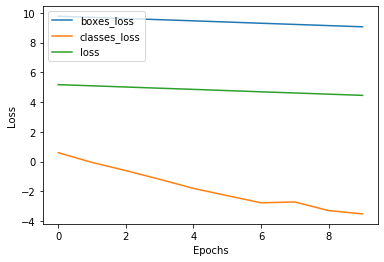

In [33]:
import matplotlib.pyplot as plt
plt.plot(np.log(history.history["head_boxes_loss"]), label="boxes_loss")
plt.plot(np.log(history.history["head_classes_loss"]), label="classes_loss")
plt.plot(np.log(history.history["loss"]), label="loss")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Displaying images and bounding box

In order to display our annotations, we build the function `plot_annotations` as follows:
- display the image
- display on top annotations and ground truth bounding boxes and classes

The `display` function:
- takes a single index and computes the result of the model
- interpret the output of the model as a bounding box
- calls the `plot_annotations` function

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

def patch(axis, bbox, display_txt, color):
    coords = (bbox[0], bbox[1]), bbox[2]-bbox[0]+1, bbox[3]-bbox[1]+1
    axis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    axis.text(bbox[0], bbox[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
def plot_annotations(img_path, annotation=None, ground_truth=None):
    img = imread(img_path)
    plt.imshow(img)
    current_axis = plt.gca()
    if ground_truth:
        text = "gt " + ground_truth["class"]
        patch(current_axis, ground_truth["bbox"], text, "red")
    if annotation:
        conf = '{:0.2f} '.format(annotation['confidence'])
        text = conf + annotation["class"]
        patch(current_axis, annotation["bbox"], text, "blue")
    plt.axis('off')
    plt.show()

def display(index, ground_truth=True):
    res = model.predict(reprs[index][np.newaxis,])
    output = interpret_output(res[0][0], res[1][0], img_size=annotations[index]["size"])
    plot_annotations("VOCdevkit/VOC2007/JPEGImages/" + annotations[index]["filename"], 
                     output, annotations[index] if ground_truth else None)

Let's display the predictions of the model and the ground truth annotation for a couple of images in our tiny debugging training set:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


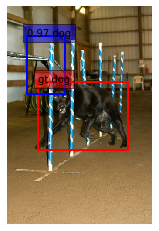

In [35]:
display(13)

The class should be right but the localization has little chance to be correct.

The model has even more trouble on images that were not part of our tiny debugging training set:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


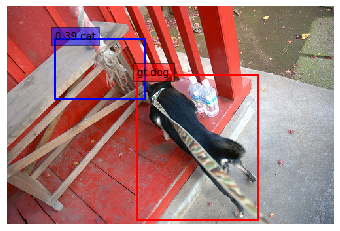

In [36]:
display(194)

### Computing Accuracy

For each example `(class_true, bbox_true)`, we consider it positive if and only if:
- the argmax of `output_class` of the model is `class_true`
- the IoU between the `output_bbox` and the `bbox_true` is above a threshold (usually `0.5`)

The accuracy of a model is then number of positive / total_number

The following functions compute the class accuracy, iou average and global accuracy:

In [0]:
# Compute class accuracy, iou average and global accuracy
def accuracy_and_iou(preds, trues, threshold=0.5):
    sum_valid, sum_accurate, sum_iou = 0, 0, 0
    num = len(preds)
    for pred, true in zip(preds, trues):
        iou_value = iou(pred["bbox"], true["bbox"])
        if pred["class"] == true["class"] and iou_value > threshold:
            sum_valid = sum_valid + 1
        sum_iou = sum_iou + iou_value
        if pred["class"] == true["class"]:
            sum_accurate = sum_accurate + 1
    return sum_accurate / num, sum_iou / num, sum_valid / num

In [0]:
# Compute the previous function on the whole train / test set
def compute_acc(train=True):
    if train:
        beg, end = 0, (9 * len(annotations) // 10)
        split_name = "train"
    else:
        beg, end = (9 * len(annotations)) // 10, len(annotations) 
        split_name = "test"
    res = model.predict(reprs[beg:end])
    outputs = []
    for index, (classes, boxes) in enumerate(zip(res[0], res[1])):
        output = interpret_output(classes, boxes,
                                  img_size=annotations[index]["size"])
        outputs.append(output)
    
    acc, iou, valid = accuracy_and_iou(outputs, annotations[beg:end],
                                       threshold=0.5)
    
    print('{} acc: {:0.3f}, mean iou: {:0.3f}, acc_valid: {:0.3f}'.format(
            split_name, acc, iou, valid) )

In [39]:
compute_acc(train=True)
compute_acc(train=False)

train acc: 0.814, mean iou: 0.036, acc_valid: 0.000
test acc: 0.795, mean iou: 0.038, acc_valid: 0.000


### Training on the whole dataset

We split our dataset into a train and a test dataset

Then train the model on the whole training set

In [40]:
# Keep last examples for test
test_num = reprs.shape[0] // 10
train_num = reprs.shape[0] - test_num
test_inputs = reprs[train_num:]
test_cls, test_boxes = classes[train_num:], boxes[train_num:]
print(train_num)

1138


In [0]:
model = classif_and_loc_stupid_model(num_classes)

In [42]:
batch_size = 32
inputs = reprs[0:train_num]
out_cls, out_boxes = classes[0:train_num], boxes[0:train_num]

history = model.fit(inputs, y=[out_cls, out_boxes], 
                    validation_data=(test_inputs, [test_cls, test_boxes]), 
                    batch_size=batch_size, epochs=10, verbose=2)

Train on 1138 samples, validate on 126 samples
Epoch 1/10
 - 1s - loss: 144.7501 - head_classes_loss: 0.7527 - head_boxes_loss: 14399.7348 - val_loss: 116.8288 - val_head_classes_loss: 0.3452 - val_head_boxes_loss: 11648.3601
Epoch 2/10
 - 0s - loss: 93.2207 - head_classes_loss: 0.2711 - head_boxes_loss: 9294.9580 - val_loss: 75.9300 - val_head_classes_loss: 0.2170 - val_head_boxes_loss: 7571.3031
Epoch 3/10
 - 0s - loss: 61.4923 - head_classes_loss: 0.2104 - head_boxes_loss: 6128.1880 - val_loss: 52.4288 - val_head_classes_loss: 0.2008 - val_head_boxes_loss: 5222.8024
Epoch 4/10
 - 0s - loss: 43.8886 - head_classes_loss: 0.1535 - head_boxes_loss: 4373.5084 - val_loss: 40.0502 - val_head_classes_loss: 0.2288 - val_head_boxes_loss: 3982.1339
Epoch 5/10
 - 0s - loss: 34.6585 - head_classes_loss: 0.1305 - head_boxes_loss: 3452.7997 - val_loss: 33.8829 - val_head_classes_loss: 0.2106 - val_head_boxes_loss: 3367.2306
Epoch 6/10
 - 0s - loss: 30.3453 - head_classes_loss: 0.1020 - head_boxes_

In [43]:
compute_acc(train=True)
compute_acc(train=False)

train acc: 1.000, mean iou: 0.340, acc_valid: 0.206
test acc: 0.913, mean iou: 0.290, acc_valid: 0.142


### Build a better model

**Exercise**

Use any tool at your disposal to build a better model:
- Dropout
- Convolution2D, Dense, with activations functions
- Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D, etc.

Notes:
- Be careful not to add too parametrized layers as you only have ~1200 training samples
- Feel free to modify hyperparameters: learning rate, optimizers, loss_weights

**Bonus**
- Add data augmentation: 
  - Flip images
  - Add random crops before resizing

In [44]:
# %load solutions/classif_and_loc.py
# test acc: 0.898, mean iou: 0.457, acc_valid: 0.496
# This is by no means the best model; however the lack
# of input data forbids us to build much deeper networks

def classif_and_loc(num_classes):
    model_input = Input(shape=(7,7,2048))
    x = GlobalAveragePooling2D()(model_input)
    
    x = Dropout(0.2)(x)
    head_classes = Dense(num_classes, activation="softmax", name="head_classes")(x)
    
    y = Convolution2D(4, 1, 1, activation='relu', name='hidden_conv')(model_input)
    y = Flatten()(y)
    y = Dropout(0.2)(y)
    head_boxes = Dense(4, name="head_boxes")(y)
    
    model = Model(model_input, outputs = [head_classes, head_boxes], name="resnet_loc")
    model.compile(optimizer="adam", loss=['categorical_crossentropy', "mse"], 
                  loss_weights=[1., 1/(224*224)]) 
    return model

model = classif_and_loc(5)

history = model.fit(x = inputs, y=[out_cls, out_boxes], 
                    validation_data=(test_inputs, [test_cls, test_boxes]), 
                    batch_size=batch_size, epochs=30, verbose=2)

compute_acc(train=True)
compute_acc(train=False)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (1, 1), activation="relu", name="hidden_conv")`
  if __name__ == '__main__':


Train on 1138 samples, validate on 126 samples
Epoch 1/30
 - 2s - loss: 1.1283 - head_classes_loss: 0.8804 - head_boxes_loss: 12435.7395 - val_loss: 0.4624 - val_head_classes_loss: 0.3827 - val_head_boxes_loss: 4003.0526
Epoch 2/30
 - 1s - loss: 0.3421 - head_classes_loss: 0.2760 - head_boxes_loss: 3318.0735 - val_loss: 0.3119 - val_head_classes_loss: 0.2595 - val_head_boxes_loss: 2626.0883
Epoch 3/30
 - 1s - loss: 0.2493 - head_classes_loss: 0.1989 - head_boxes_loss: 2528.1058 - val_loss: 0.2869 - val_head_classes_loss: 0.2419 - val_head_boxes_loss: 2256.2200
Epoch 4/30
 - 1s - loss: 0.1945 - head_classes_loss: 0.1525 - head_boxes_loss: 2109.9452 - val_loss: 0.3072 - val_head_classes_loss: 0.2660 - val_head_boxes_loss: 2066.3036
Epoch 5/30
 - 1s - loss: 0.1656 - head_classes_loss: 0.1287 - head_boxes_loss: 1851.5165 - val_loss: 0.2674 - val_head_classes_loss: 0.2302 - val_head_boxes_loss: 1867.8584
Epoch 6/30
 - 1s - loss: 0.1391 - head_classes_loss: 0.1060 - head_boxes_loss: 1656.703

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


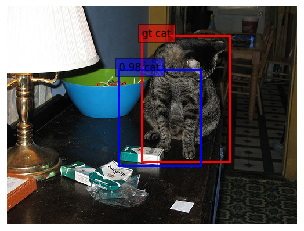

In [45]:
display(1242)